In [1]:
import os
import cv2
import math
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Example: 


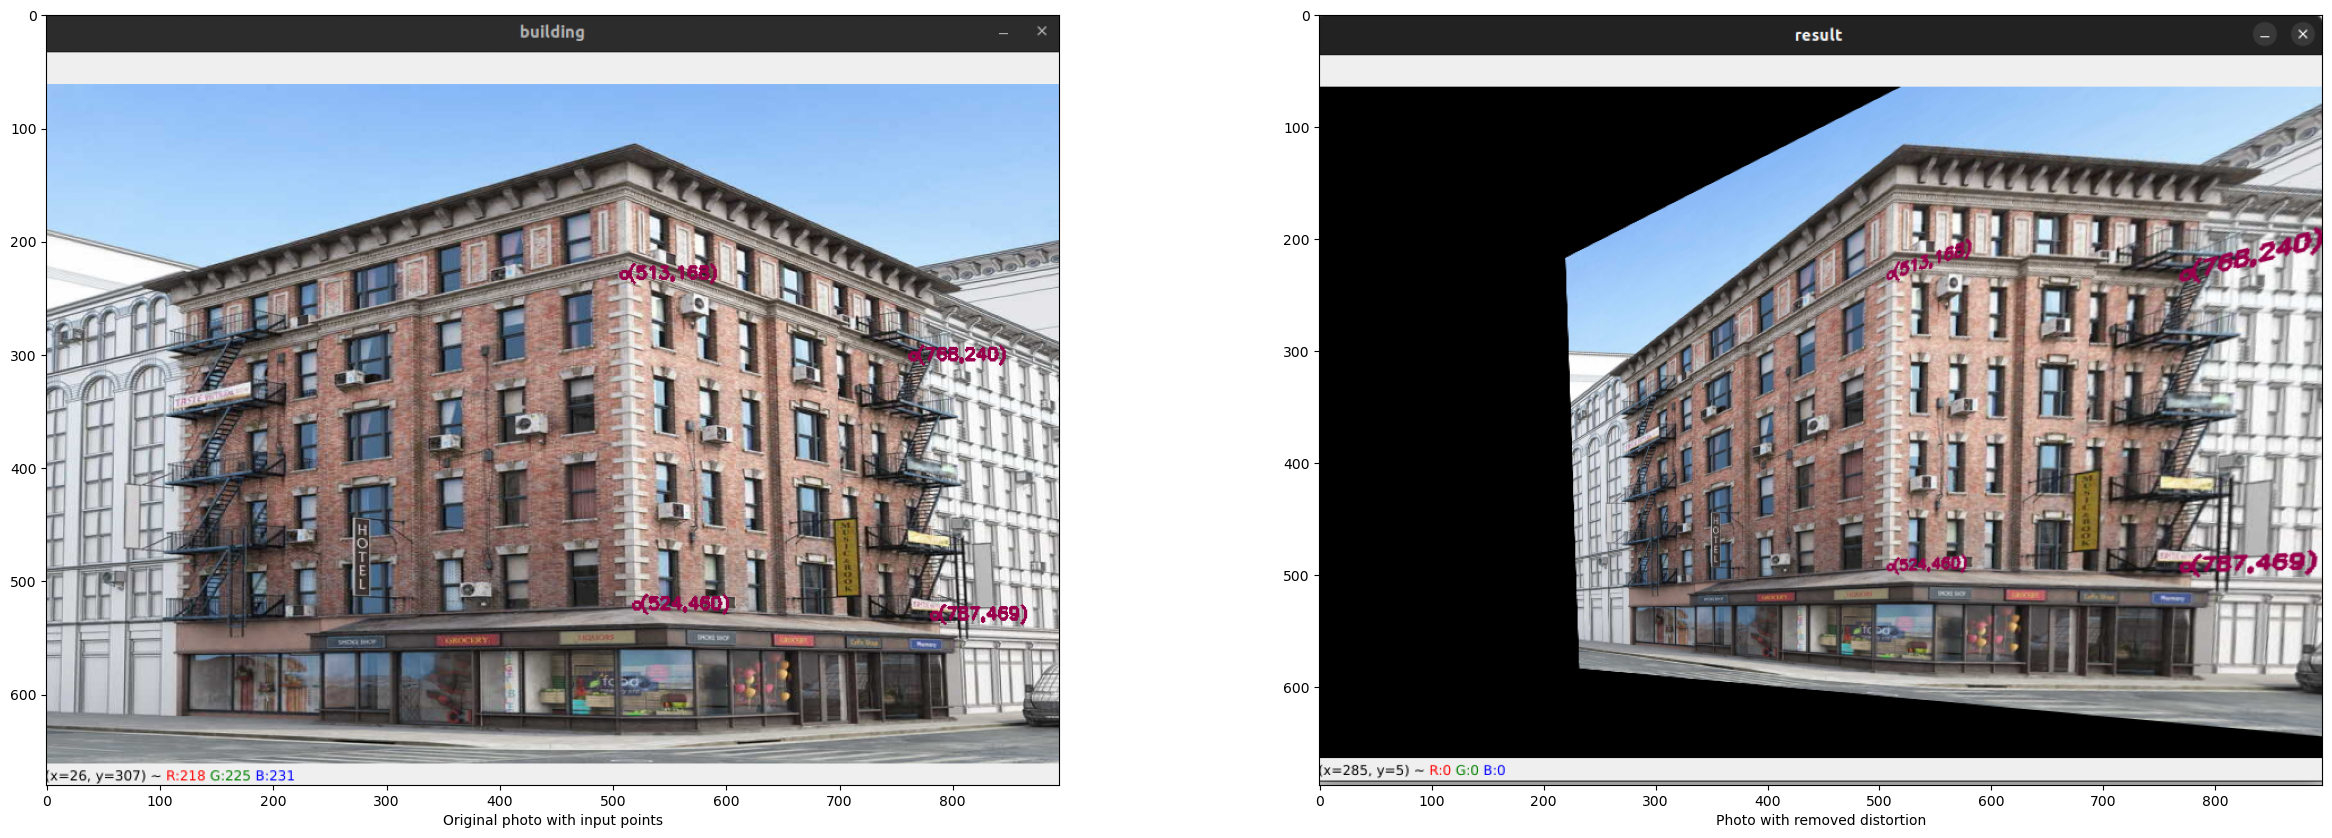

In [2]:
print(f'Example: ')
original_image = mpimg.imread('images/img_1.png')
image_with_removed_distortion = mpimg.imread('images/img_2.png')

figure = plt.subplots(1, 2, figsize= (30, 10))
plt.subplot(1, 2, 1)
plt.xlabel('Original photo with input points')
plt.imshow(original_image)

plt.subplot(1, 2, 2)
plt.xlabel('Photo with removed distortion')
plt.imshow(image_with_removed_distortion)
plt.show()

### DLT algorithm

In [3]:
def calculate_matrix_for_DLT(original_points, projected_points):
    matrix = []
    
    for i in range(len(original_points)):
        matrix.append([
            0.0, 0.0, 0.0, 
            -projected_points[i][2] * original_points[i][0], -projected_points[i][2] * original_points[i][1], -projected_points[i][2] * original_points[i][2],
            projected_points[i][1] * original_points[i][0], projected_points[i][1] * original_points[i][1], projected_points[i][1] * original_points[i][2]
        ])
        
        matrix.append([
            projected_points[i][2] * original_points[i][0], projected_points[i][2] * original_points[i][1], projected_points[i][2] * original_points[i][2],
            0.0, 0.0, 0.0,
            -projected_points[i][0] * original_points[i][0], -projected_points[i][0] * original_points[i][1], -projected_points[i][0] * original_points[i][2]
        ])
    
    return matrix

In [4]:
def DLT_algorithm(original_points, projected_points):
    A = calculate_matrix_for_DLT(original_points, projected_points)
    _, _, V = np.linalg.svd(A, full_matrices= True)
    
    return V[-1].reshape(3, 3)

### Removing projective distortion

In [5]:
def find_file(filename, search_path):
    result = []
    
    for root, dir, files in os.walk(search_path):
        if filename in files:
            result.append(os.path.join(root, filename))
    return result

In [6]:
def find_projections(original_points):
    projections = []
    
    AD = math.sqrt((original_points[0][0] - original_points[3][0]) ** 2 
                 + (original_points[0][1] - original_points[3][1]) ** 2)
    BC = math.sqrt((original_points[1][0] - original_points[2][0]) ** 2
                 + (original_points[1][1] - original_points[2][1]) ** 2)
    
    width = round((AD + BC) / 2.0)
    
    
    AB = math.sqrt((original_points[0][0] - original_points[1][0]) ** 2 
                 + (original_points[0][1] - original_points[1][1]) ** 2)
    DC = math.sqrt((original_points[3][0] - original_points[2][0]) ** 2
                 + (original_points[3][1] - original_points[2][1]) ** 2)
    
    height = round((AB + DC) / 2.0)
    
    projections.append([original_points[0][0], original_points[0][1], original_points[0][2]])
    projections.append([original_points[0][0], original_points[0][1] + width, original_points[0][2]])
    projections.append([original_points[0][0] + height, original_points[0][1] + width, original_points[0][2]])
    projections.append([original_points[0][0] + height, original_points[0][1], original_points[0][2]])
    
    return projections

In [7]:
# y-axis
def sort_input_points_by_y_coordinate(points):
    sorted_points = sorted(points)
    
    if sorted_points[1][1] < sorted_points[0][1]:
        sorted_points[0], sorted_points[1] = sorted_points[1], sorted_points[0]
    if sorted_points[2][1] < sorted_points[3][1]:
        sorted_points[2], sorted_points[3] = sorted_points[3], sorted_points[2]
        
    return sorted_points

In [8]:
image_size = (900, 600)
original_points = []
counter = 0

def on_click(event, x, y, flags, param):
    global original_points, image, counter, image_size
    
    if event == cv2.EVENT_LBUTTONDOWN:
            if counter < 4:
                counter += 1
                original_points.append([x, y, 1])
                
                xp = x + 3
                yp = y + 3
                font = cv2.FONT_HERSHEY_SIMPLEX
                color = (76, 0, 153)
                text = '(' + str(x) + ',' + str(y) + ')'
            
                cv2.circle(image, (x, y), 3, color, 2)
                cv2.putText(image, text, (xp, yp), font, 0.5, color, 2)
                cv2.imshow('building', image)
            
            if counter == 4:
                projections = find_projections(original_points)
                original_points = sort_input_points_by_y_coordinate(original_points)
                
                P_DLT = DLT_algorithm(original_points, projections)
                output = cv2.warpPerspective(image, P_DLT, image_size)
                
                cv2.imshow('result', output)
                cv2.waitKey(0)

In [9]:
image_name = input('Input image name: ')
path = find_file(image_name, '.')

Input image name: building.bmp


In [ ]:
image = cv2.imread(str(path[0]), cv2.IMREAD_COLOR)
image = cv2.resize(image, image_size, interpolation= cv2.INTER_AREA)
cv2.imshow('building', image)
cv2.setMouseCallback('building', on_click)
cv2.waitKey(0)
cv2.exit(0)
cv2.destroyAllWindows()
cv2.waitKey(1)